<a href="https://colab.research.google.com/github/imraunav/Computer-vision-EE511/blob/main/optical_flow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!wget --no-check-certificate https://www.crcv.ucf.edu/data/UCF101/UCF101.rar > op
!unrar x UCF101.rar >> op

--2023-11-25 09:47:07--  https://www.crcv.ucf.edu/data/UCF101/UCF101.rar
Resolving www.crcv.ucf.edu (www.crcv.ucf.edu)... 132.170.214.127
Connecting to www.crcv.ucf.edu (www.crcv.ucf.edu)|132.170.214.127|:443... connected.
  Unable to locally verify the issuer's authority.
HTTP request sent, awaiting response... 200 OK
Length: 6932971618 (6.5G) [application/rar]
Saving to: ‘UCF101.rar’

UCF101.rar          100%[===================>]   6.46G  62.9MB/s    in 8m 6s   

2023-11-25 09:55:13 (13.6 MB/s) - ‘UCF101.rar’ saved [6932971618/6932971618]



In [16]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
from scipy import signal
import os
from tqdm import tqdm

In [17]:
path = "/content/UCF-101/YoYo/v_YoYo_g16_c01.avi"

In [18]:
def read_video(path):
    vid_capture = cv2.VideoCapture(path)
    fps = vid_capture.get(cv2.CAP_PROP_FPS)
    print('Frames per second : ', fps,'FPS')
    frame_count = vid_capture.get(cv2.CAP_PROP_FRAME_COUNT)
    print('Frame count : ', frame_count)

    frames = []
    for _ in tqdm(range(int(frame_count))):
        ret, frame = vid_capture.read()
        if ret == True:
            # frame = cv2.resize(frame, resize_shape)
            # cv2.imwrite(os.path.join(video_path, str(frame_counter)+".jpg"), frame)
            frames.append(frame)
        else:
            break
    return frames

In [19]:
frames = read_video(path)
print(len(frames))

Frames per second :  25.0 FPS
Frame count :  162.0


100%|██████████| 162/162 [00:00<00:00, 696.48it/s]

162


In [20]:
# for frame in frames:
#     plt.imshow(frame[:,:,::-1])
#     plt.show()

In [83]:
def opticalFlow(img1,img2,frameIndex,totalFrames, t=0.7):
	h,w = img1.shape[:2]
	colorImage1 = cv2.cvtColor(img1,cv2.COLOR_BGR2RGB)

	img1G = cv2.cvtColor(img1,cv2.COLOR_BGR2GRAY)
	img2G = cv2.cvtColor(img2,cv2.COLOR_BGR2GRAY)

	img1 = np.array(img1G)
	img2 = np.array(img2G)

	img1_smooth = cv2.GaussianBlur(img1,(3,3),0)
	img2_smooth = cv2.GaussianBlur(img2,(3,3),0)

	Ix = signal.convolve2d(img1_smooth,[[-0.25, 0.25],[-0.25, 0.25]],'same') + signal.convolve2d(img2_smooth,[[-0.25, 0.25],[-0.25, 0.25]],'same')
	Iy = signal.convolve2d(img1_smooth,[[-0.25,-0.25],[ 0.25, 0.25]],'same') + signal.convolve2d(img2_smooth,[[-0.25,-0.25],[ 0.25, 0.25]],'same')
	It = signal.convolve2d(img1_smooth,[[ 0.25, 0.25],[ 0.25, 0.25]],'same') + signal.convolve2d(img2_smooth,[[-0.25,-0.25],[-0.25,-0.25]],'same')

	features = cv2.goodFeaturesToTrack(img1_smooth,10000,0.01,10)
	feature = np.int0(features)

	u = np.nan*np.ones((h,w))
	v = np.nan*np.ones((h,w))

	for l in feature:
		j,i = l.ravel()

		IX,IY,IT = [],[],[]

		if(i+2 < h and i-2 > 0 and j+2 < w and j-2 > 0):
			for b1 in range(-2,3):
				for b2 in range(-2,3):
					IX.append(Ix[i+b1,j+b2])
					IY.append(Iy[i+b1,j+b2])
					IT.append(It[i+b1,j+b2])

			LK = (IX,IY)
			LK = np.matrix(LK)
			LK_T = np.array(np.matrix(LK))
			LK = np.array(np.matrix.transpose(LK))

			A1 = np.dot(LK_T,LK)
			A2 = np.linalg.pinv(A1)
			A3 = np.dot(A2,LK_T)

			(u[i,j],v[i,j]) = np.dot(A3,IT)

  #white img
	blank = np.full(colorImage1.shape, 255, dtype=np.uint8)
	fig = plt.figure()
	plt.subplot(1,1,1)
	plt.axis('off')
	# plt.imshow(colorImage1, cmap = 'gray')
	plt.imshow(blank, origin="lower", extent=[1,4,2,8])
	for i in range(h):
		for j in range(w):
			if abs(u[i,j]) > t or abs(v[i,j]) > t:
				plt.arrow(j,i,1.5*(-1*u[i,j]),1.5*(-1*v[i,j]), head_width = 3, head_length = 3, color = 'red')

	# print('\r({:4}/{:4}) - Time Elapsed: {:10.10} seconds'.format(frameIndex+1,totalFrames,time.time()-start), end='')

	fig.canvas.draw()
	img = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
	img = img.reshape(fig.canvas.get_width_height()[::-1] + (3,))
	img = cv2.cvtColor(img,cv2.COLOR_RGB2BGR)
	plt.close()

	return img

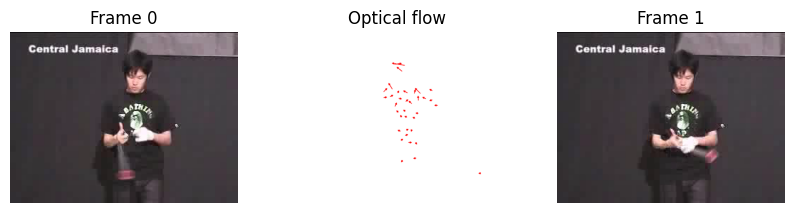

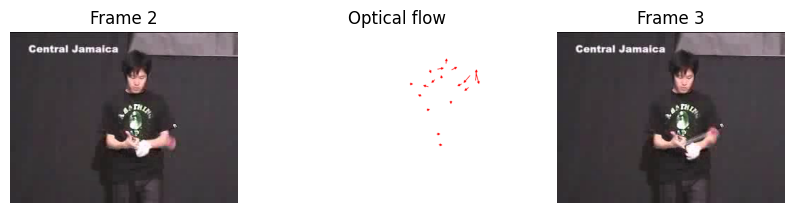

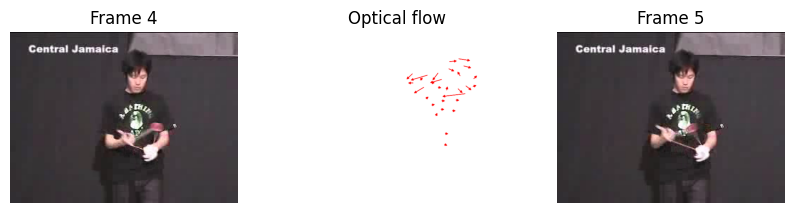

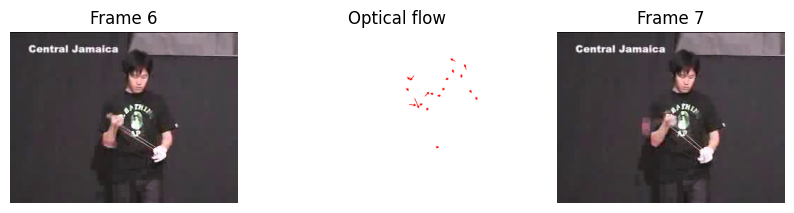

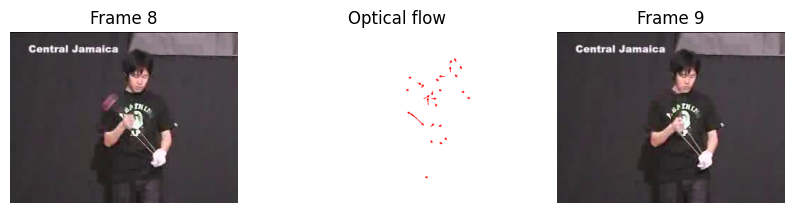

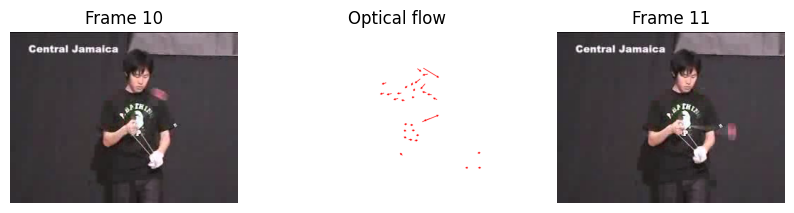

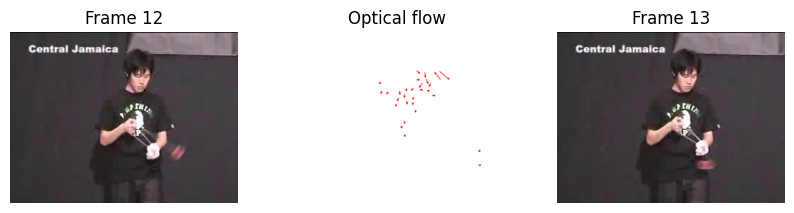

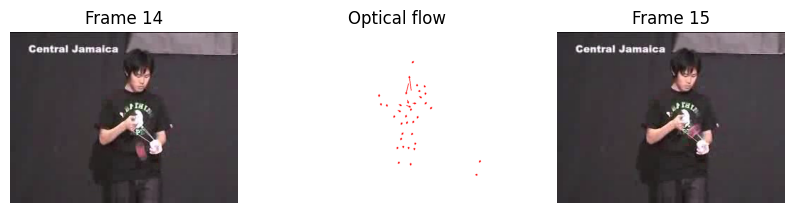

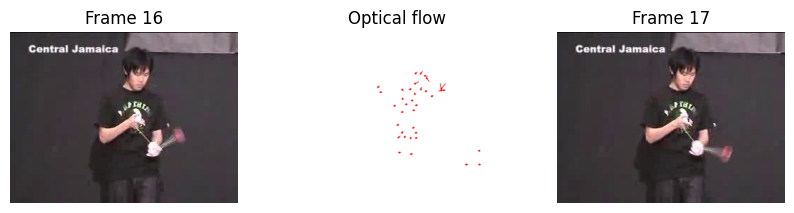

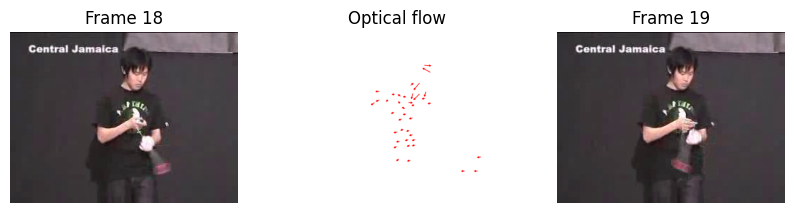

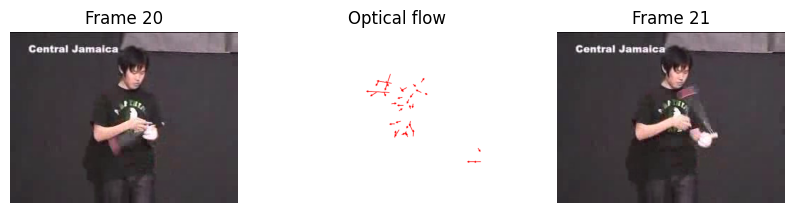

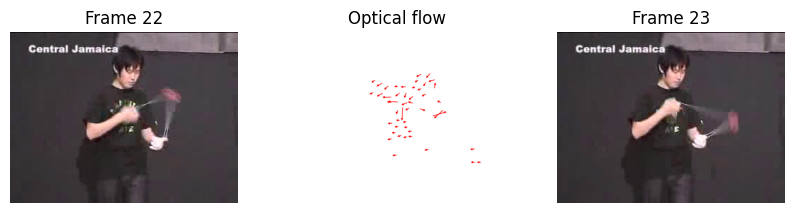

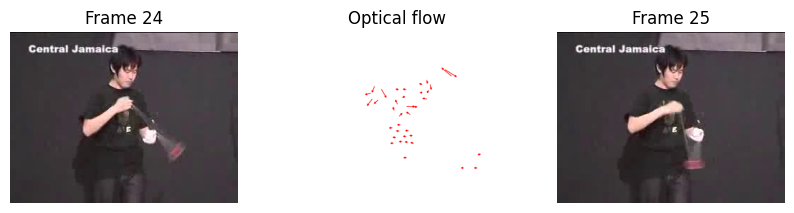

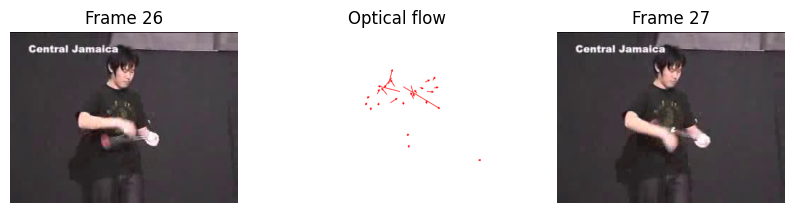

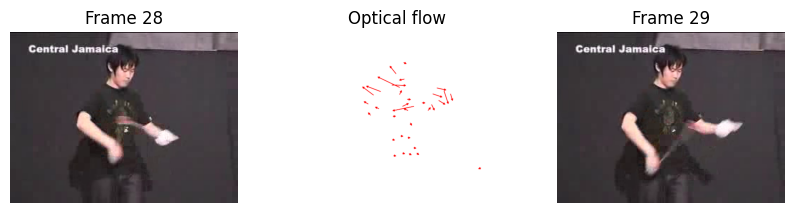

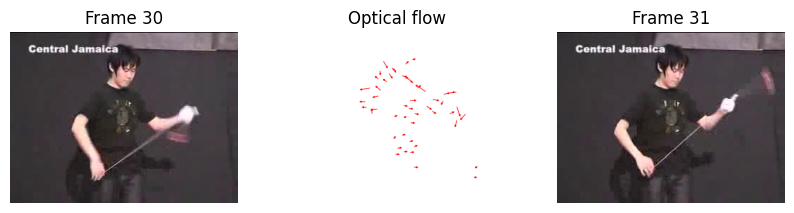

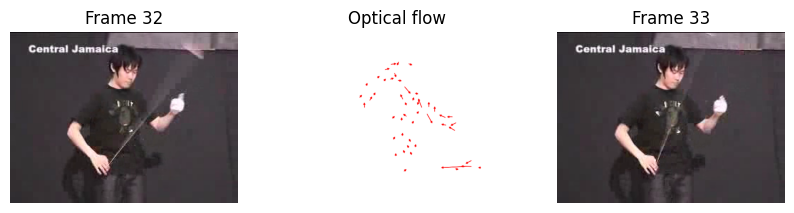

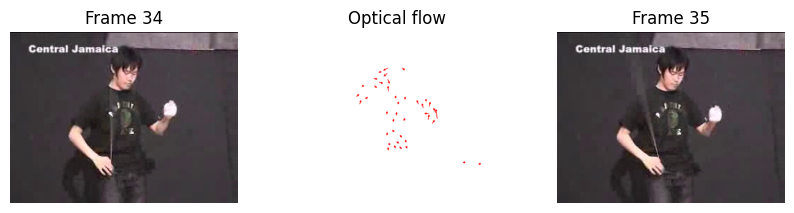

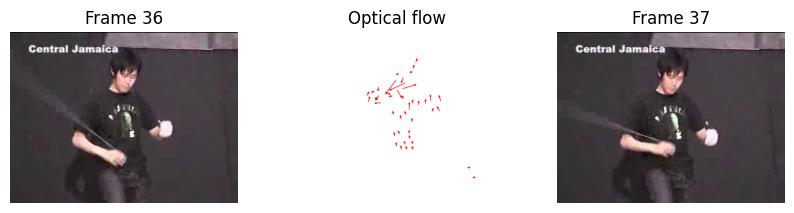

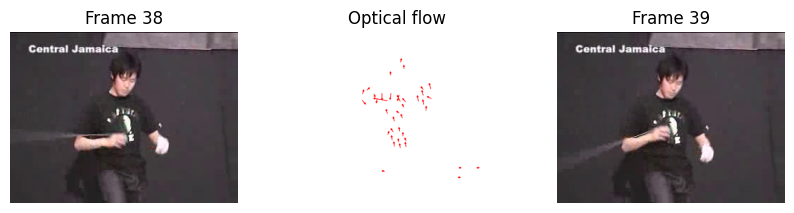

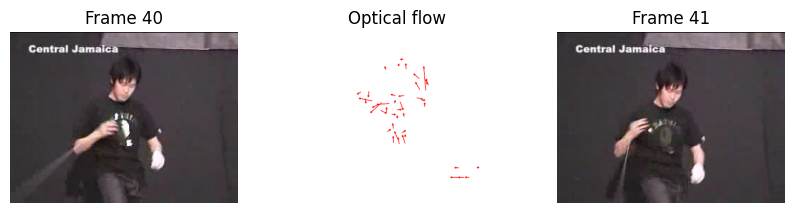

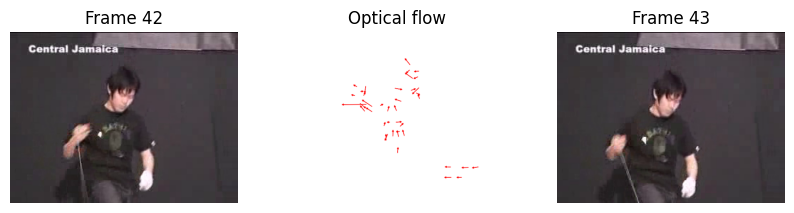

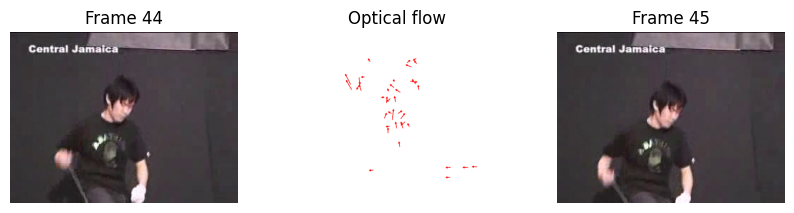

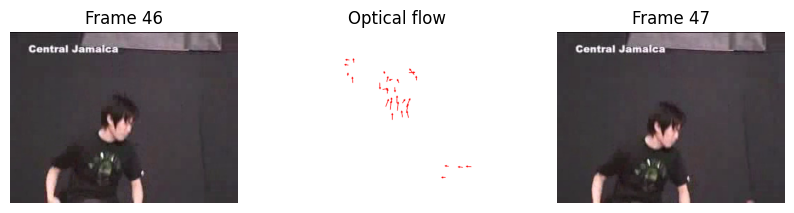

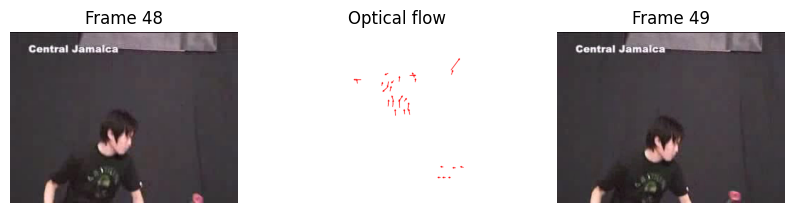

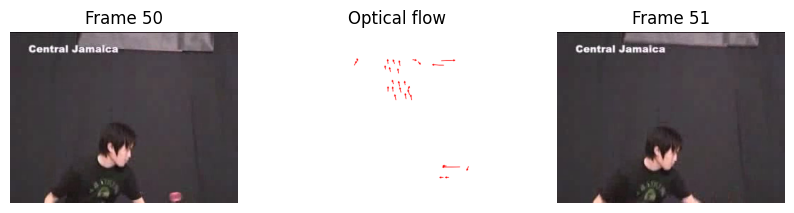

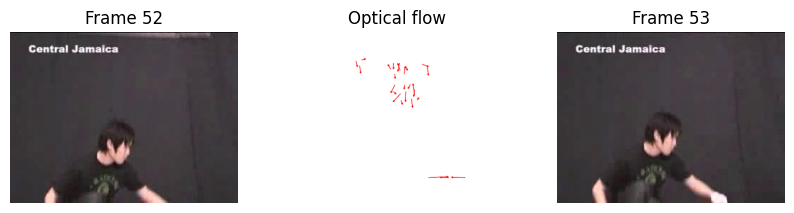

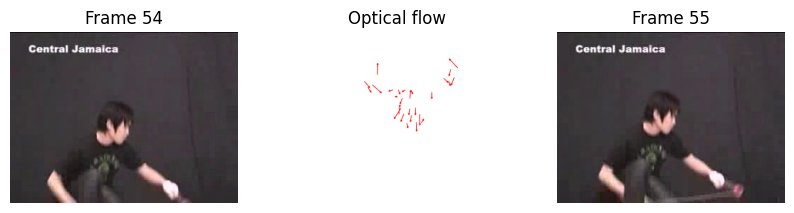

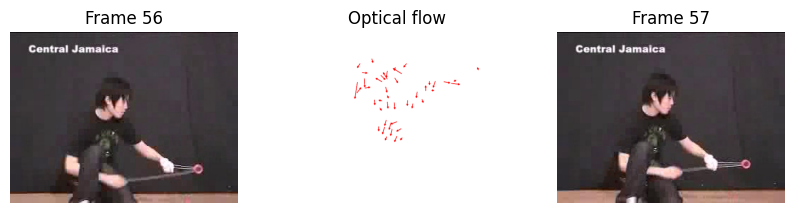

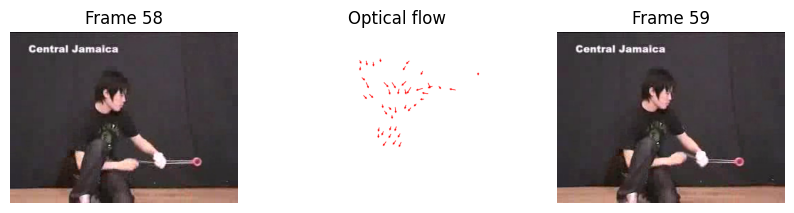

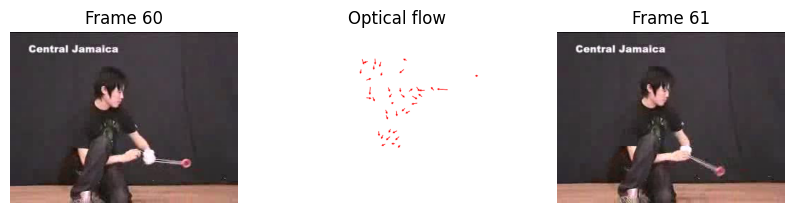

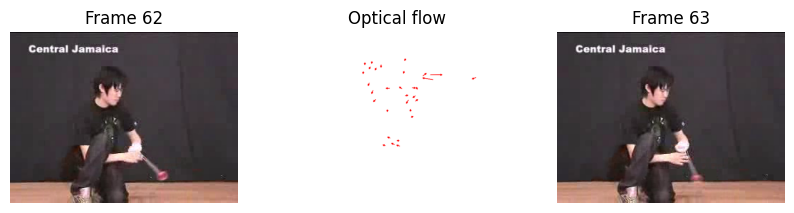

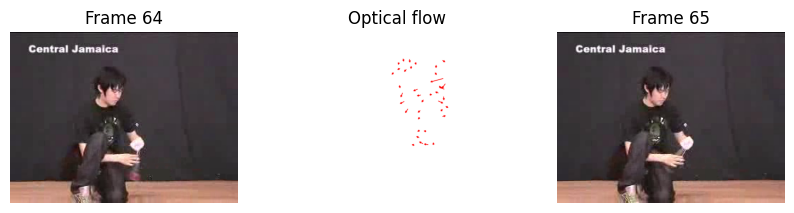

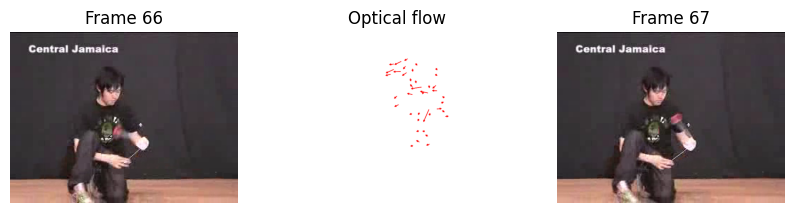

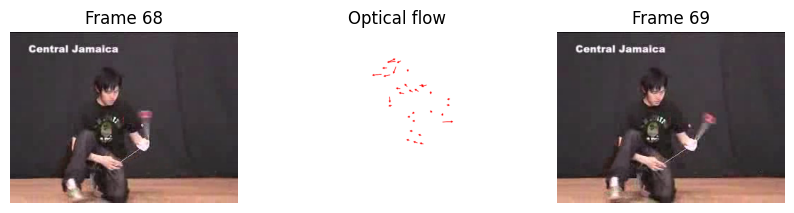

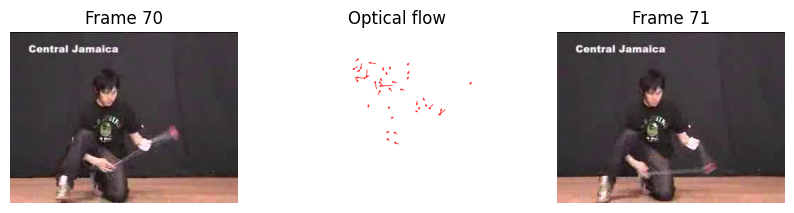

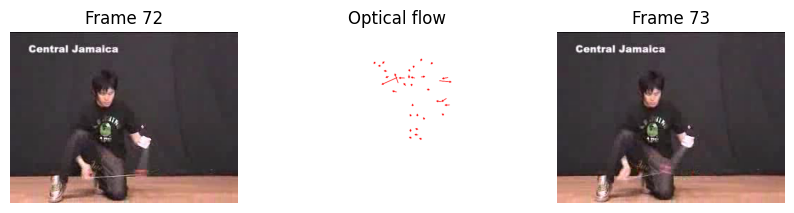

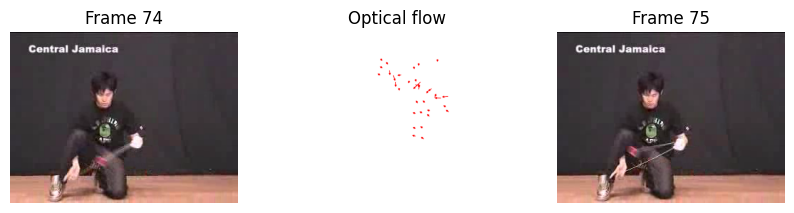

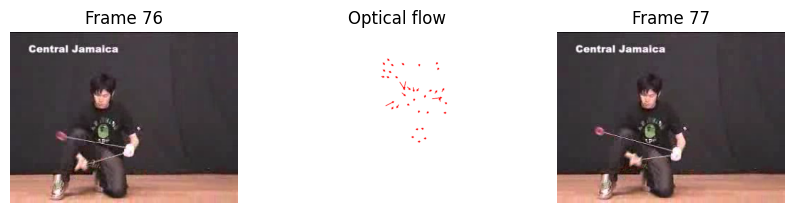

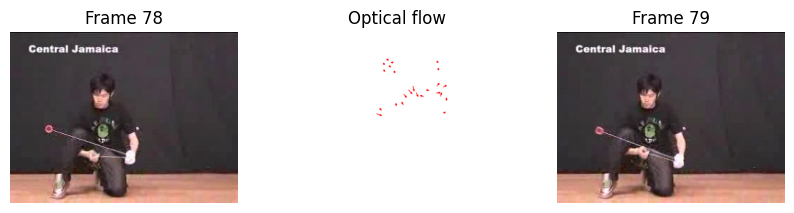

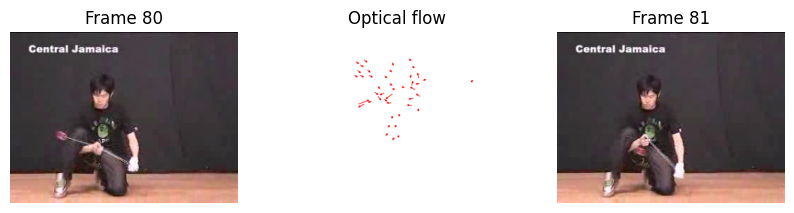

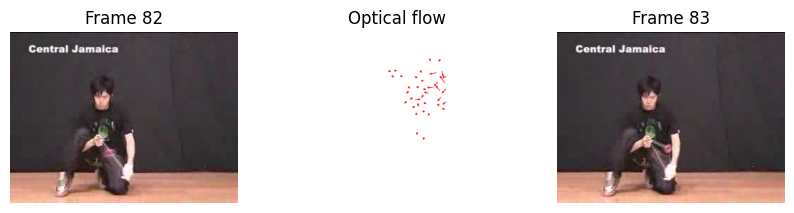

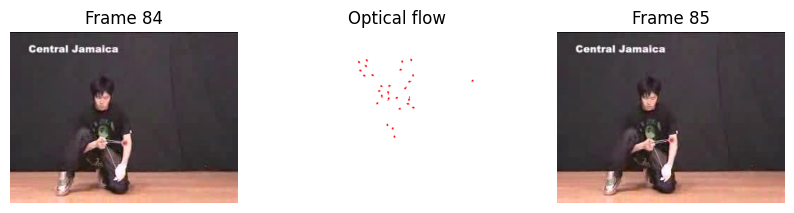

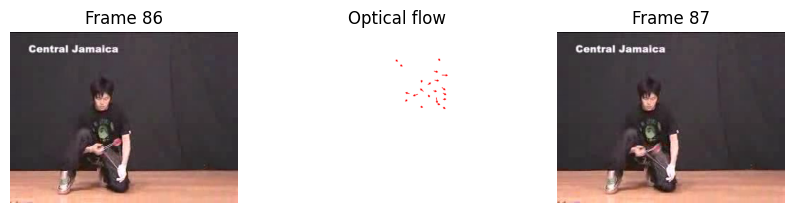

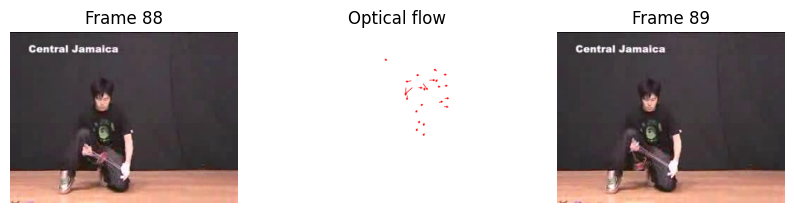

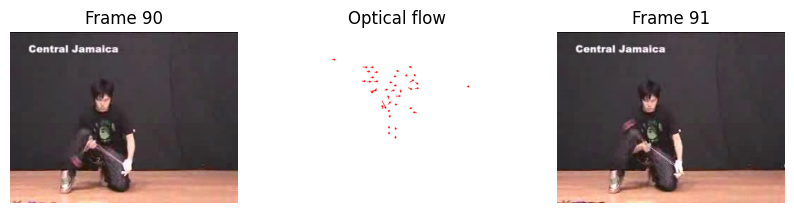

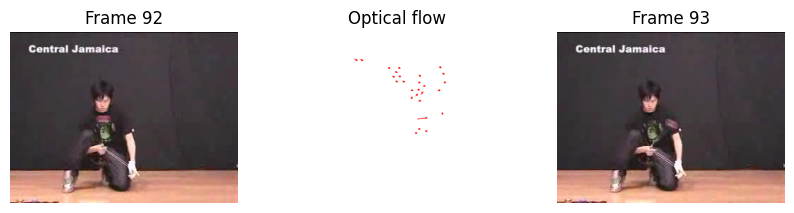

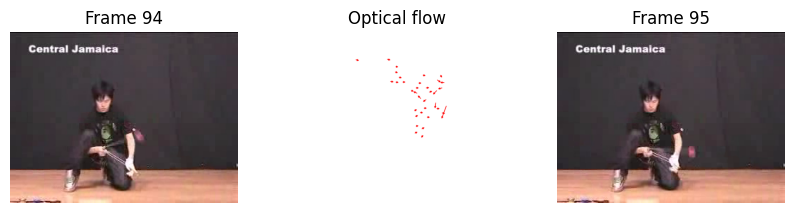

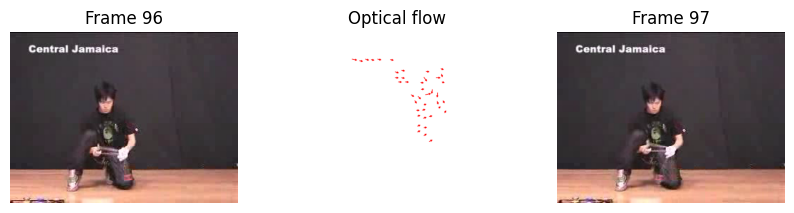

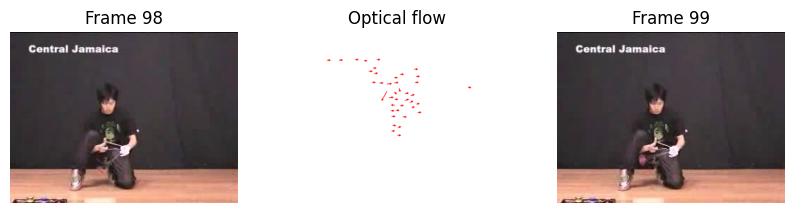

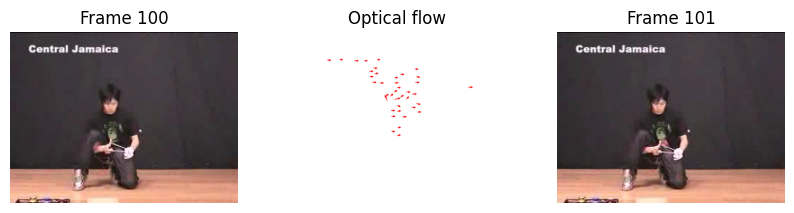

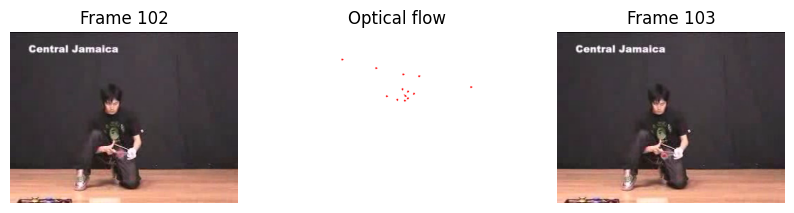

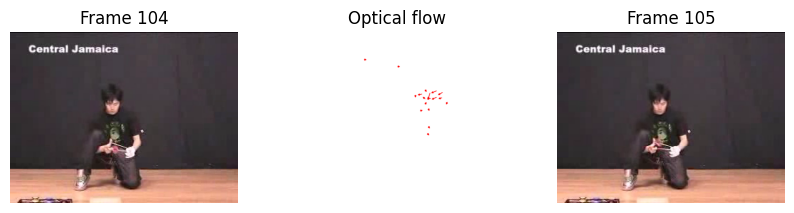

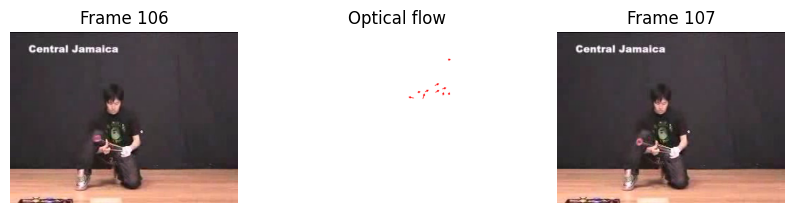

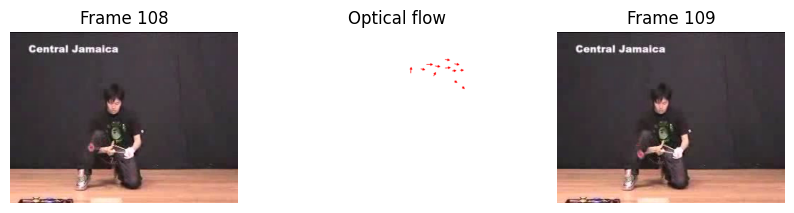

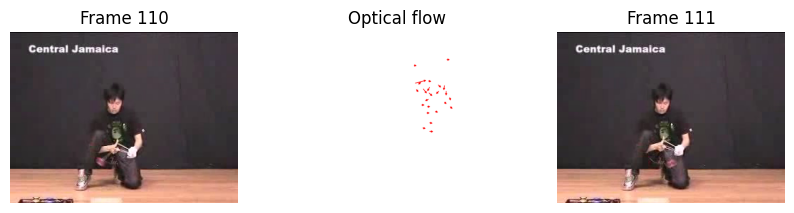

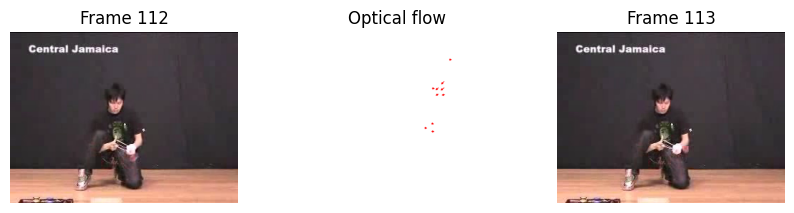

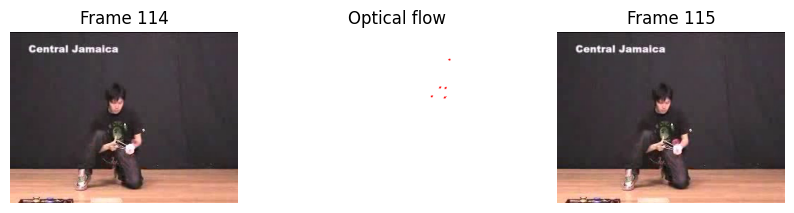

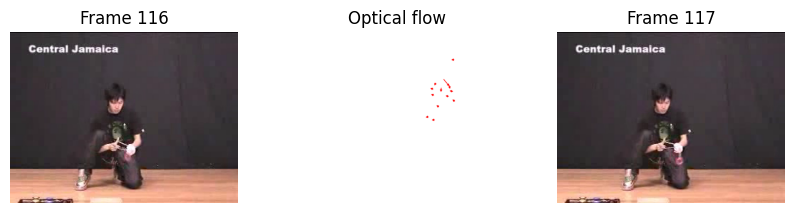

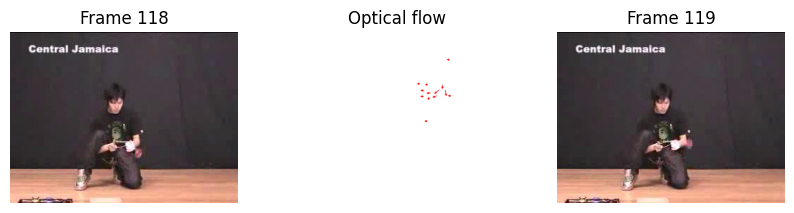

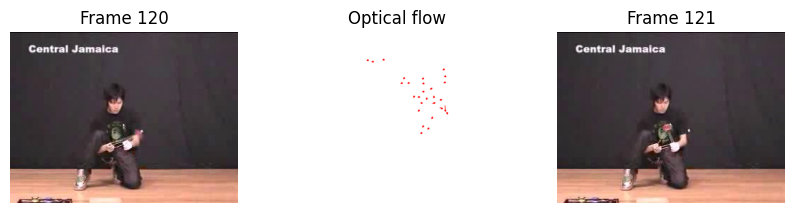

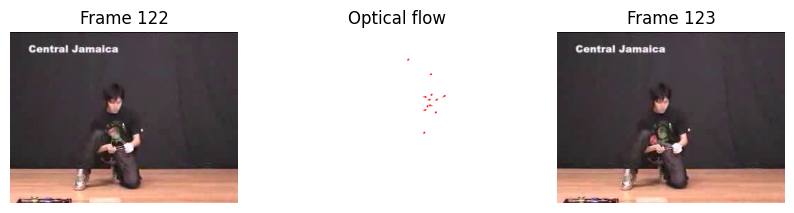

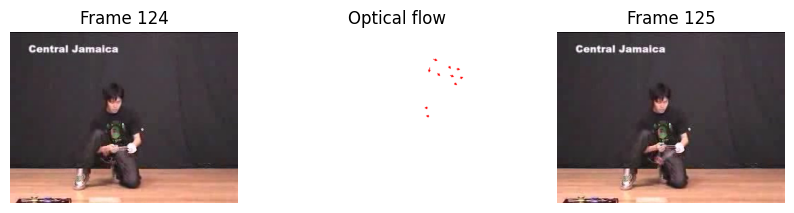

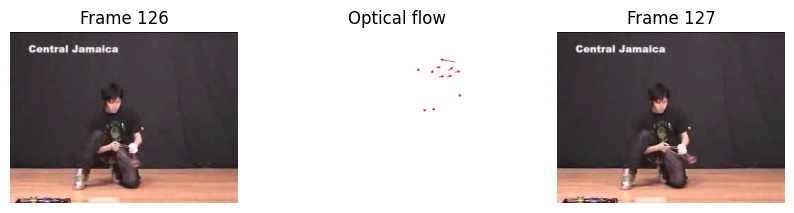

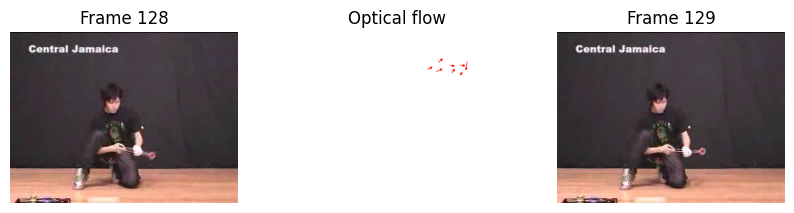

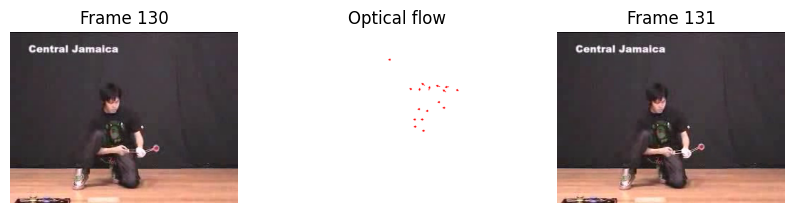

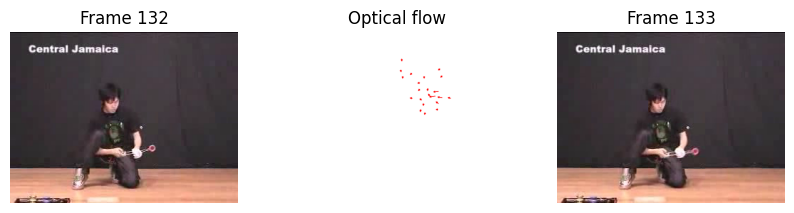

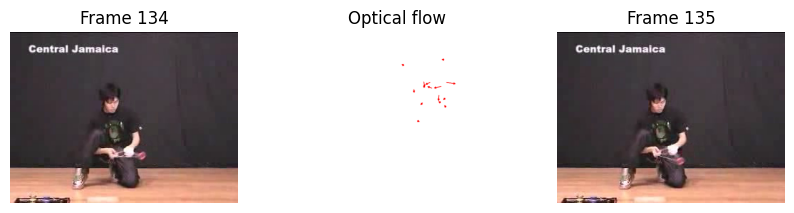

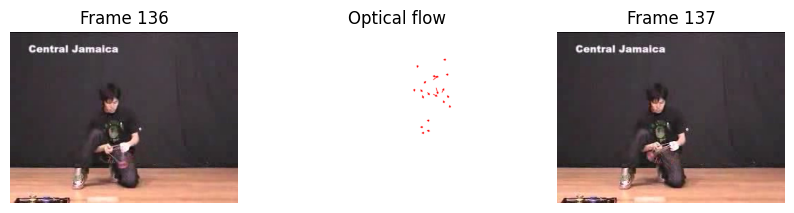

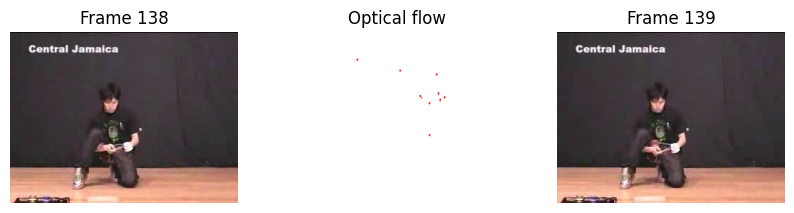

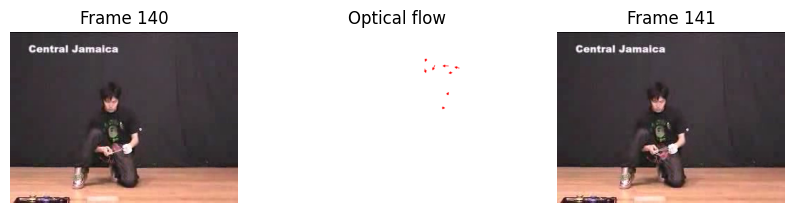

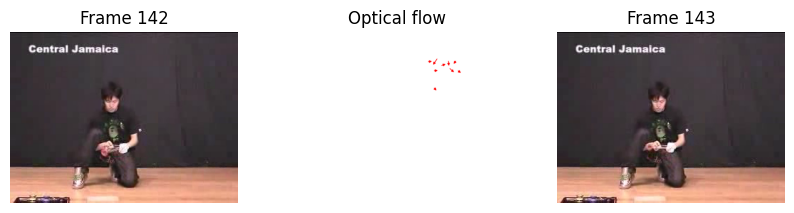

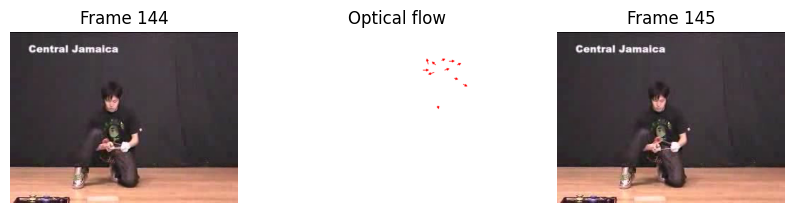

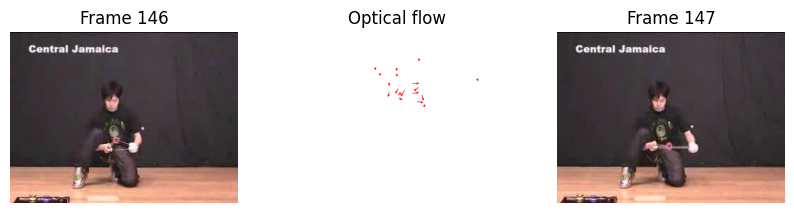

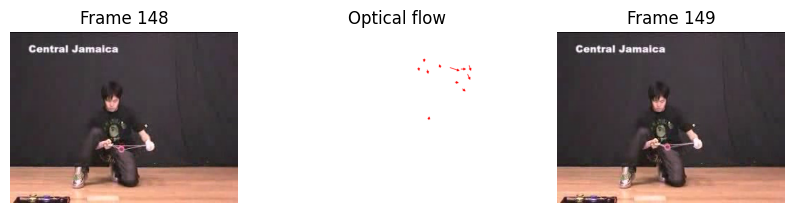

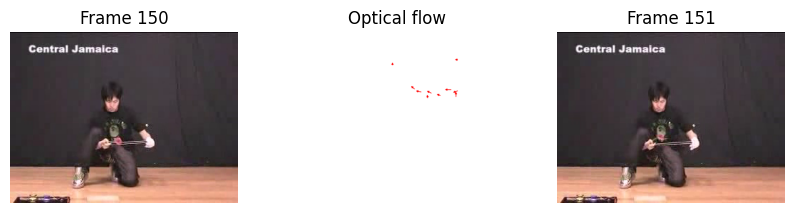

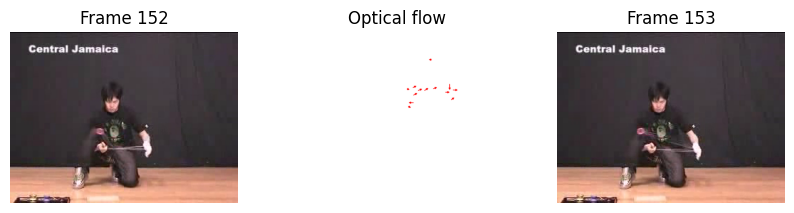

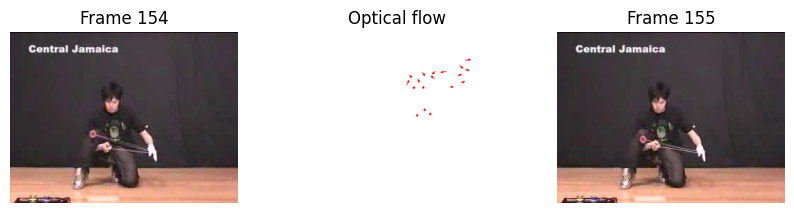

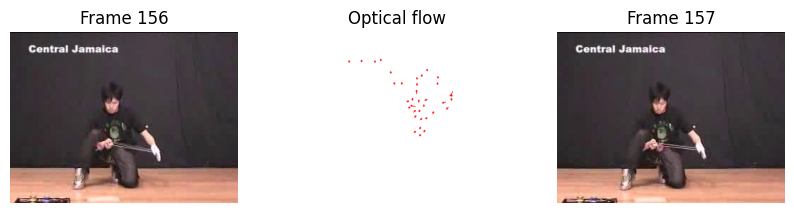

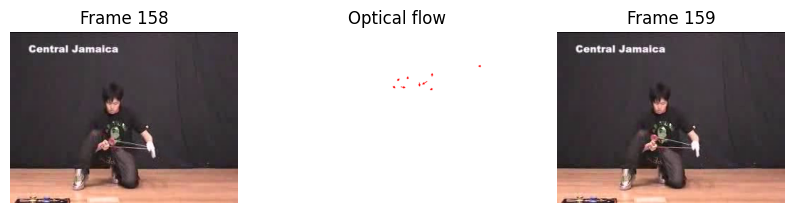

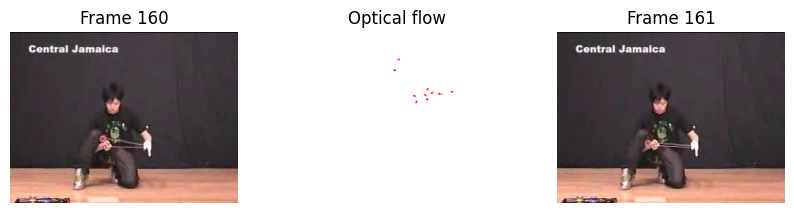

In [89]:
nframes = len(frames)
for i in range(0, nframes, 2):
  f1 = frames[i]
  f2 = frames[i+1]

  flow = opticalFlow(f1, f2, i, nframes, t=0.5)

  plt.figure(figsize=(10,8))
  plt.subplot(1, 3, 1)
  plt.title(f"Frame {i}")
  plt.imshow(f1[:,:,::-1])
  plt.axis('off')

  plt.subplot(1, 3, 2)
  plt.title(f"Optical flow")
  plt.imshow(flow[:, :, ::-1])
  plt.axis('off')


  plt.subplot(1, 3, 3)
  plt.title(f"Frame {i+1}")
  plt.imshow(f2[:,:,::-1])
  plt.axis('off')

  plt.show()

  # break

